In [1]:
# %pip install kagglehub
# %pip install monai
# %pip install ipywidgets
# %pip install pillow tensorflow scikit-learn
# %pip install opencv-python

In [2]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import torch
from monai.transforms import ScaleIntensity
import kagglehub

#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [3]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/brain_tumor_dataset/yes/.DS_Store
# !rm -rf {path}/brain_tumor_dataset/no/.DS_Store

In [5]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_norma = f'{path}/brain_tumor_dataset/no'

#### Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_norma:", count_images(dataset_path_norma))

Length dataset_path_tumor: 155
Length dataset_path_norma: 98


#### Check data

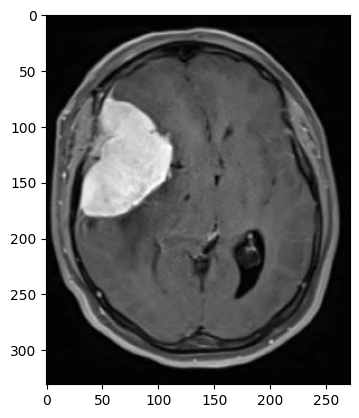

In [7]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y243.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

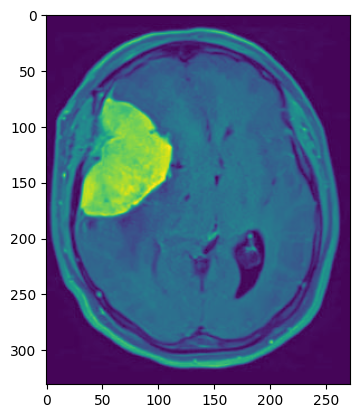

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform_img(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess images

In [9]:
img_size = (256, 256)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

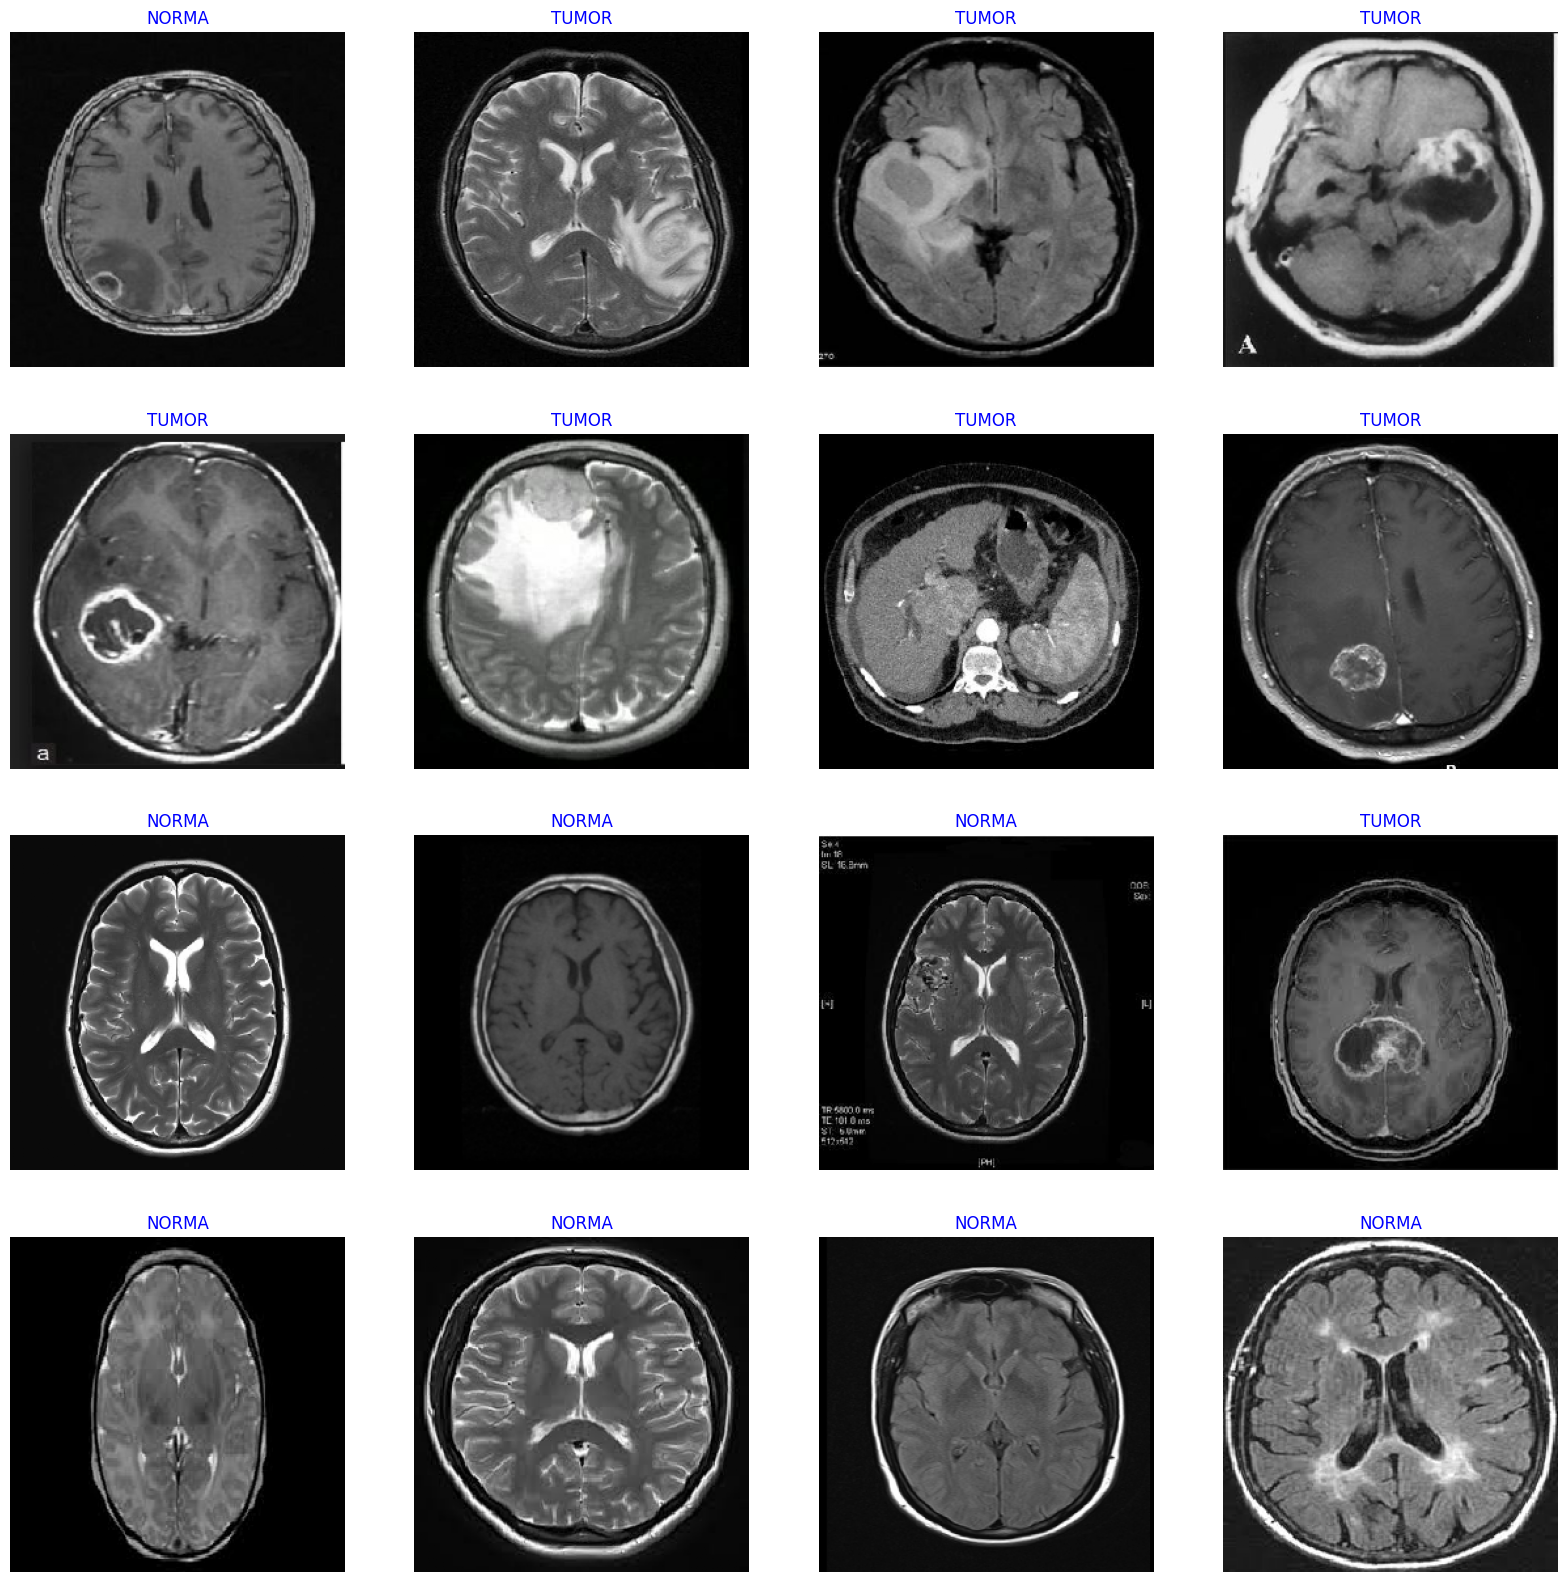

In [10]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_norma, 'NORMA')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'NORMA': 0, 'TUMOR': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [11]:
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=155)
normal_data, normal_labels = load_and_limit_data(dataset_path_norma, label=0, num_samples=98)

all_data = np.concatenate([tumor_data, normal_data], axis=0)
all_labels = np.concatenate([tumor_labels, normal_labels], axis=0)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

#### Convert labels to one-hot encoded format

In [12]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

#### Build CNN classical model

In [13]:
classical_model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

#### Compile the model

In [14]:
classical_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the model and store the training history

In [15]:
clasical_history = classical_model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 0.5904 - loss: 156.9667 - val_accuracy: 0.6667 - val_loss: 9.3491
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.7723 - loss: 4.8740 - val_accuracy: 0.7647 - val_loss: 1.1244
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 0.7211 - loss: 0.6089 - val_accuracy: 0.7255 - val_loss: 0.6315
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.8005 - loss: 0.4197 - val_accuracy: 0.7647 - val_loss: 0.7899
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.8915 - loss: 0.3005 - val_accuracy: 0.7647 - val_loss: 0.6672
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 0.8403 - loss: 0.3328 - val_accuracy: 0.7451 - val_loss: 1.6176
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.8837 - loss: 0.3207 - val_accuracy: 0.7843 - val_loss: 0.7521
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.9045 - loss: 0.2160 - val_accuracy: 0.7843 - val_los

In [16]:
loss, accuracy = classical_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7964 - loss: 1.3257
Test Accuracy: 80.39%
Test Loss: 1.3400


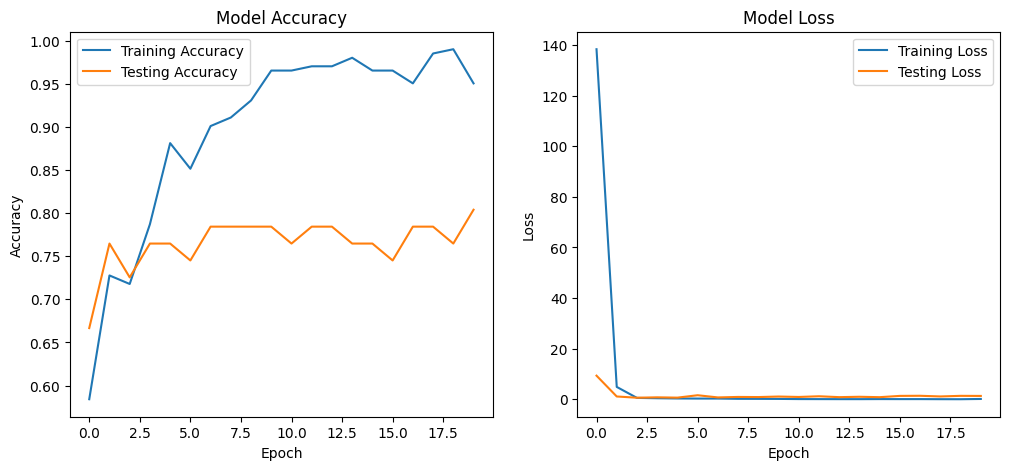

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(clasical_history.history['accuracy'], label='Training Accuracy')
plt.plot(clasical_history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(clasical_history.history['loss'], label='Training Loss')
plt.plot(clasical_history.history['val_loss'], label='Testing Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### The evaluation of model

In [18]:
y_pred_probabilities = classical_model.predict(X_test)

y_pred = np.argmax(y_pred_probabilities, axis=1)

y_pred_categorical = np.eye(2)[y_pred]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


#### Compute evaluation metrics

In [19]:
y_test_labels = np.argmax(y_test, axis=1)

classification_rep = metrics.classification_report(y_test_labels, y_pred, output_dict=True, zero_division=True)

conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred)

roc_auc = metrics.roc_auc_score(y_test_labels, y_pred_probabilities[:, 1])

print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report:
 {'0': {'precision': 0.7916666666666666, 'recall': 0.7916666666666666, 'f1-score': 0.7916666666666666, 'support': 24.0}, '1': {'precision': 0.8148148148148148, 'recall': 0.8148148148148148, 'f1-score': 0.8148148148148148, 'support': 27.0}, 'accuracy': 0.803921568627451, 'macro avg': {'precision': 0.8032407407407407, 'recall': 0.8032407407407407, 'f1-score': 0.8032407407407407, 'support': 51.0}, 'weighted avg': {'precision': 0.803921568627451, 'recall': 0.803921568627451, 'f1-score': 0.803921568627451, 'support': 51.0}}
Confusion Matrix:
 [[19  5]
 [ 5 22]]
ROC AUC Score: 0.8441358024691358


#### Predicted probability for Positive Class

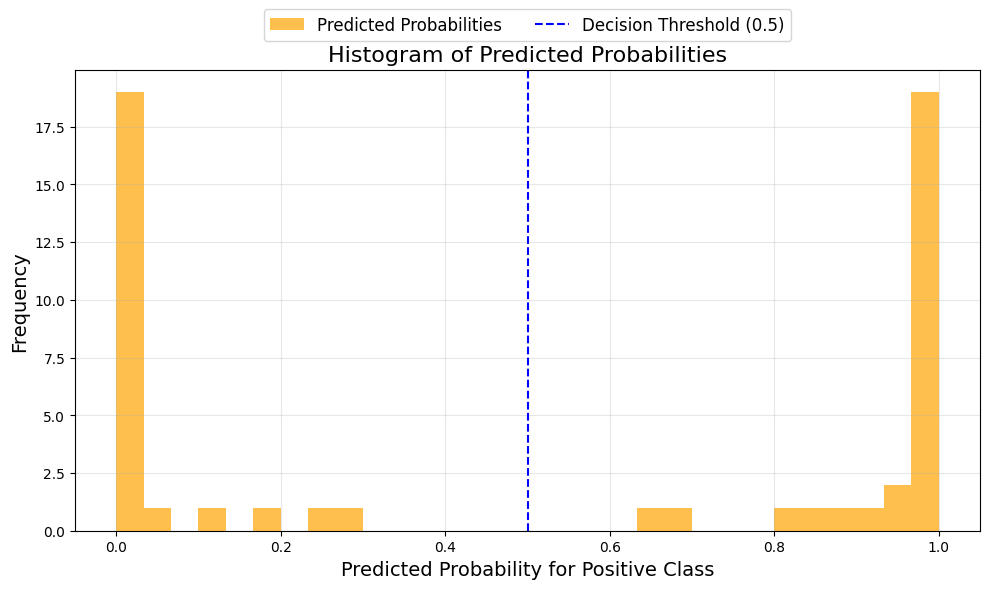

In [20]:
y_pred_probabilities_tensor = torch.tensor(y_pred_probabilities, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor[:, 1]

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

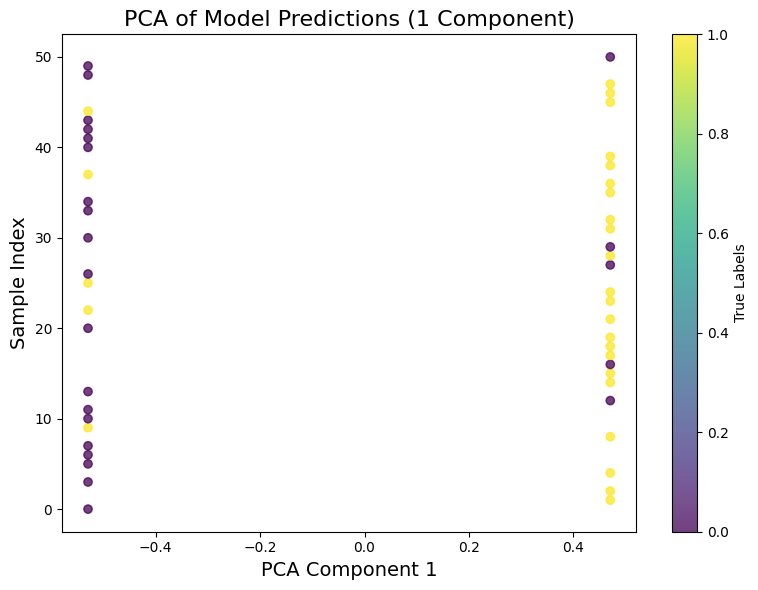

In [21]:
labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

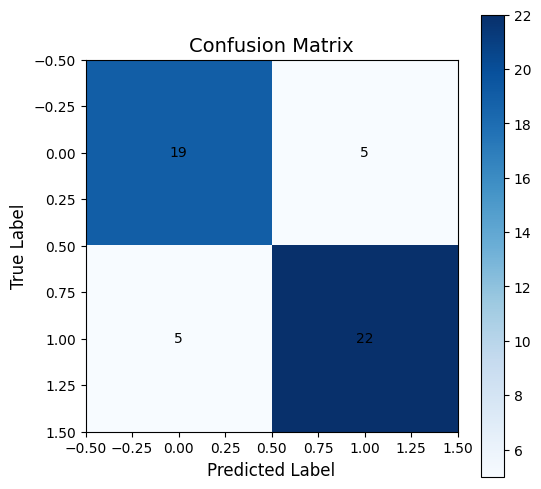

In [22]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()